In [1]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi, isclose
from scipy.linalg import cholesky, eigh, solve

from tudaesasII.beam2d import Beam2D, update_K, update_M, DOF


nx = 100

# geometry
Lbeam = 2
h = 0.05
w = h
Izz = h**3*w/12
A = w*h

# material properties
E = 70e9
nu = 0.33
rho = 2.6e3

# creating mesh
xmesh = np.linspace(0, Lbeam, nx)
ymesh = np.zeros_like(xmesh)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]
nid_pos = dict(zip(np.arange(len(ncoords)), np.arange(len(ncoords))))

#NOTE using dense matrices
N = DOF*nx
K = np.zeros((N, N))
M = np.zeros((N, N))

elems = []
# creating beam elements
nids = list(nid_pos.keys())
for n1, n2 in zip(nids[:-1], nids[1:]):
    elem = Beam2D()
    elem.n1 = n1
    elem.n2 = n2
    elem.E = E
    elem.A1 = elem.A2 = A
    elem.Izz1 = elem.Izz2 = Izz
    elem.rho = rho
    elem.interpolation = 'legendre'
    update_K(elem, nid_pos, ncoords, K)
    update_M(elem, nid_pos, M)
    elems.append(elem)

print('elements created')

# applying boundary conditions for static problem
# cantilever
bk = np.zeros(K.shape[0], dtype=bool) #array to store known DOFs
check = isclose(x, 0.)
bk[0::DOF] = check
bk[1::DOF] = check
bk[2::DOF] = check
bk[0::DOF] = True

u = np.zeros(K.shape[0])

bu = ~bk

Muu = M[bu, :][:, bu]
Mku = M[bk, :][:, bu]
Muk = M[bu, :][:, bk]
Mkk = M[bk, :][:, bk]

Kuu = K[bu, :][:, bu]
Kku = K[bk, :][:, bu]
Kuk = K[bu, :][:, bk]
Kkk = K[bk, :][:, bk]

L = cholesky(M, lower=True)
Luu = L[bu, :][:, bu]
Luuinv = np.linalg.inv(Luu)
Ktilde = Luuinv @ Kuu @ Luuinv.T

rbmodes = 0
Nmodes = 12
gamma, Vu = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
Vu = Vu[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

V = np.zeros((N, Nmodes-rbmodes))
V[bu, :] = Vu

P = V
Pu = Vu

print('omegan [rad/s]', omegan)


elements created
omegan [rad/s] [   65.82334046   412.20991137  1152.8553918   2255.30247436
  3719.99131684  5542.0742096   7715.99984241 10235.26509686
 13092.50469998 16279.56803512 19787.60253586 23607.14081456]


C:\Users\jsodja\AppData\Local\Temp\ipykernel_6416\2065357499.py:92: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  gamma, Vu = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1


Direct Frequency Response Analysis (with base excitation)
===
Damping matrix C calculated from modal damping ratio
---

In [2]:
zeta = 0.02
Dm = np.zeros((Nmodes-rbmodes, Nmodes-rbmodes))
Dm[np.diag_indices_from(Dm)] = 2*zeta*omegan
C = L @ P @ Dm @ P.T @ L.T
Cuu = C[bu, :][:, bu]
Cuk = C[bu, :][:, bk]

Sine sweep analysis
---

In [3]:
amplitude = 0.001
u = np.zeros(N)
u[1] = amplitude
uk = u[bk]

displs = []
U = np.zeros(K.shape[0], dtype=np.complex128)
omegas = np.linspace(0, 6000, 1000)
for omegaf in omegas:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk 
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    Uu = solve(Huu, Fk)
    
    U[bu] = Uu
    U[1] = amplitude
    displs.append(U[1::DOF].copy())   
displs = np.asarray(displs)
print('ready')

ready


(0.0, 40.38105756678595)

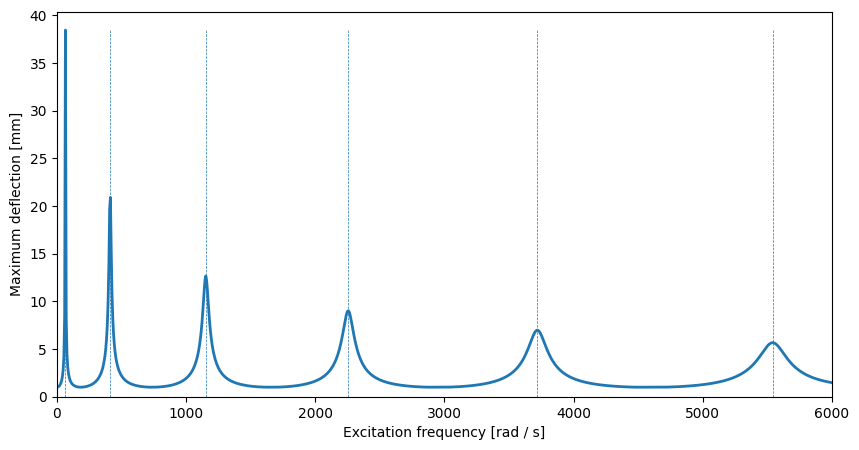

In [4]:
%matplotlib inline
phase = np.arctan2(displs.imag, displs.real)
plt.plot(omegas, np.abs(displs).max(axis=1)*1000)
plt.vlines(x=[omegan[omegan < omegas.max()]], ymin=0, ymax=np.abs(displs).max()*1000, ls='--', lw=0.5)
plt.ylabel('Maximum deflection [mm]')
plt.xlabel('Excitation frequency [rad / s]')
plt.xlim(0, 6000)
plt.ylim(0, 1.05*np.abs(displs).max()*1000)

[   65.82334046   412.20991137  1152.8553918   2255.30247436
  3719.99131684  5542.0742096   7715.99984241 10235.26509686
 13092.50469998 16279.56803512 19787.60253586]
ready


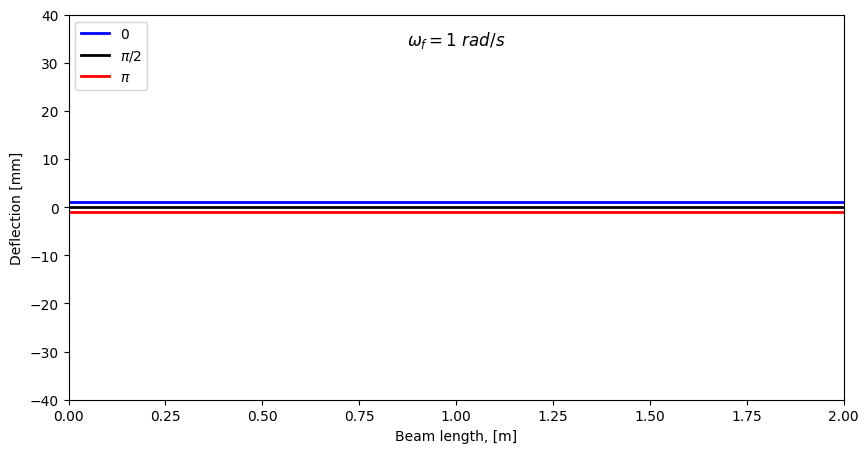

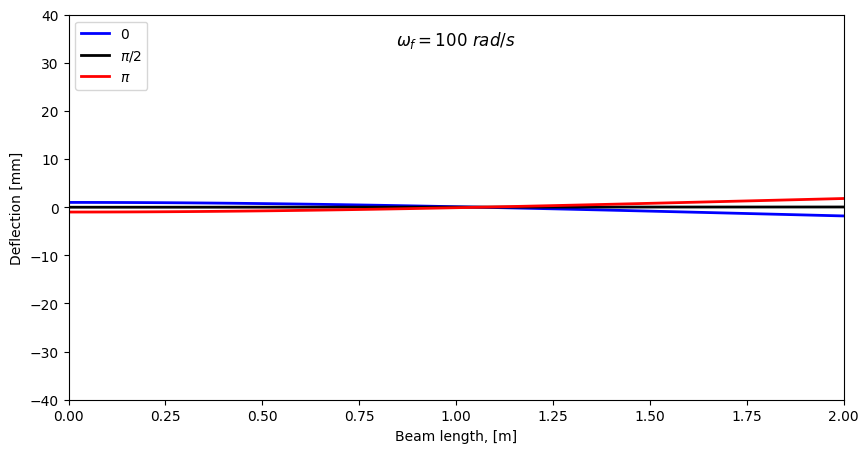

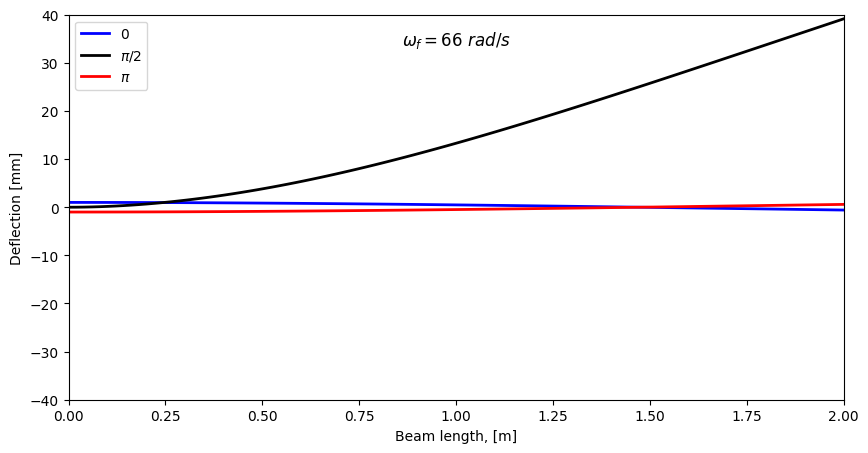

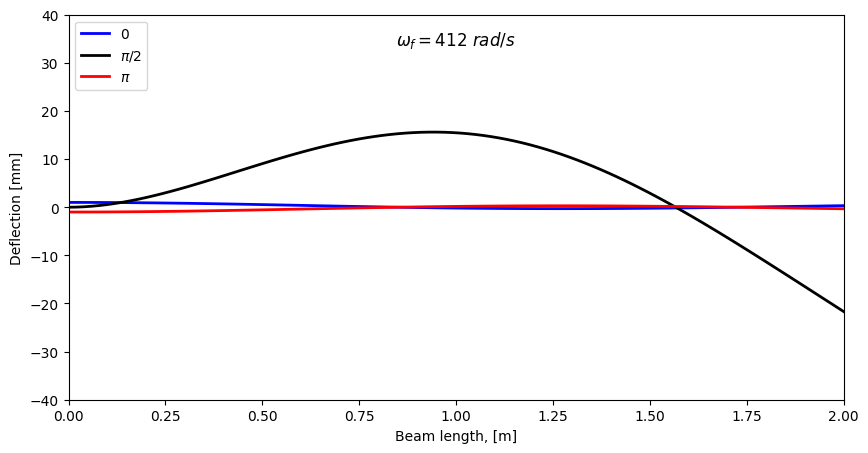

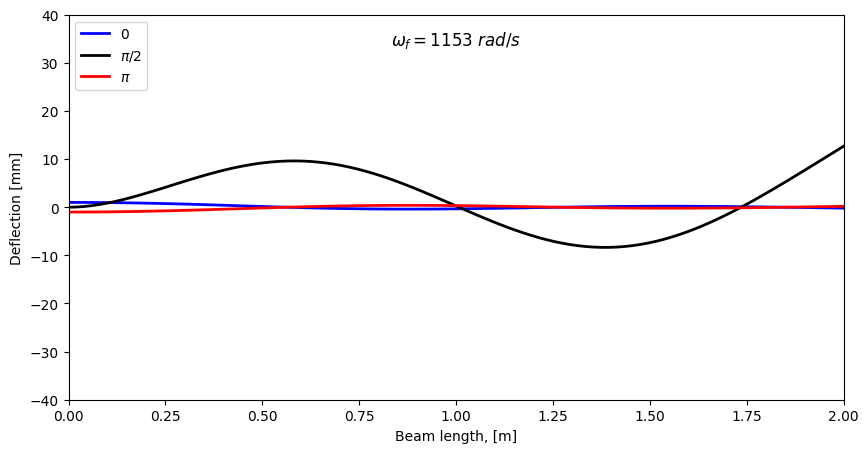

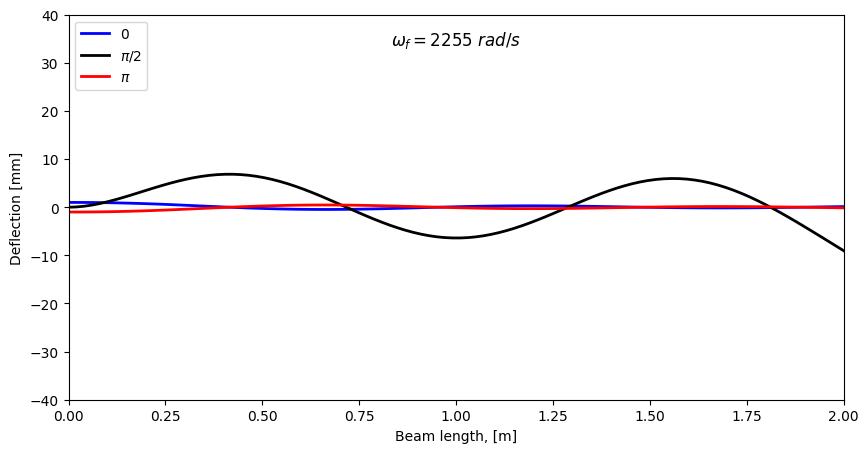

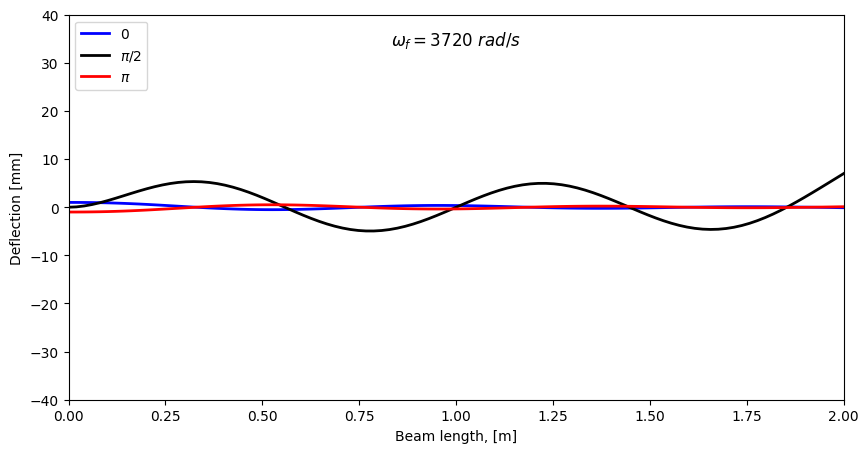

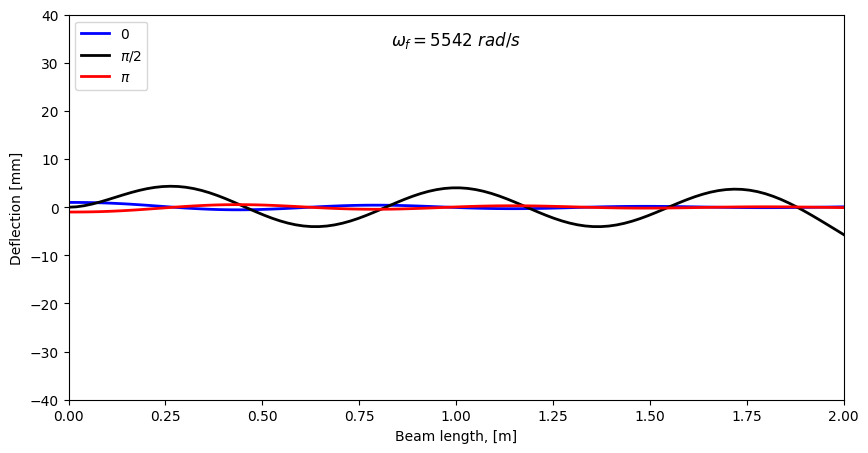

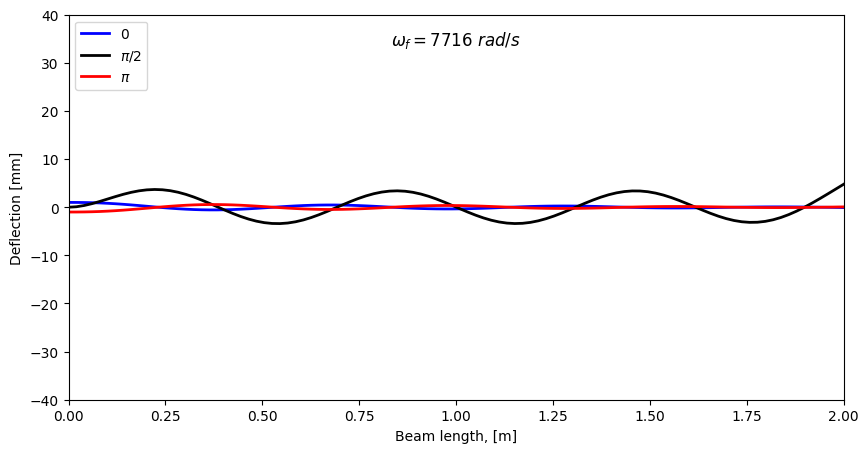

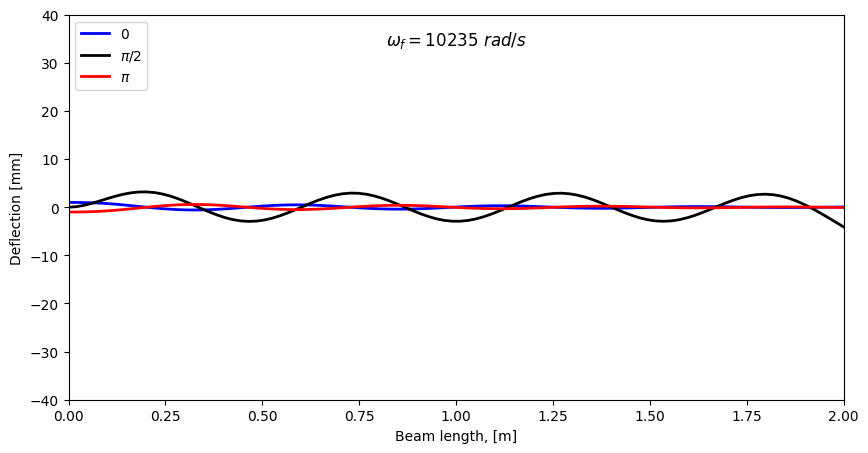

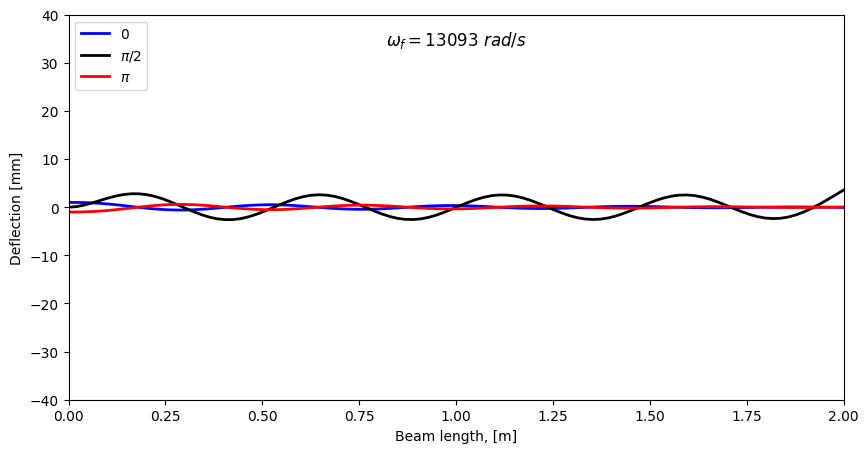

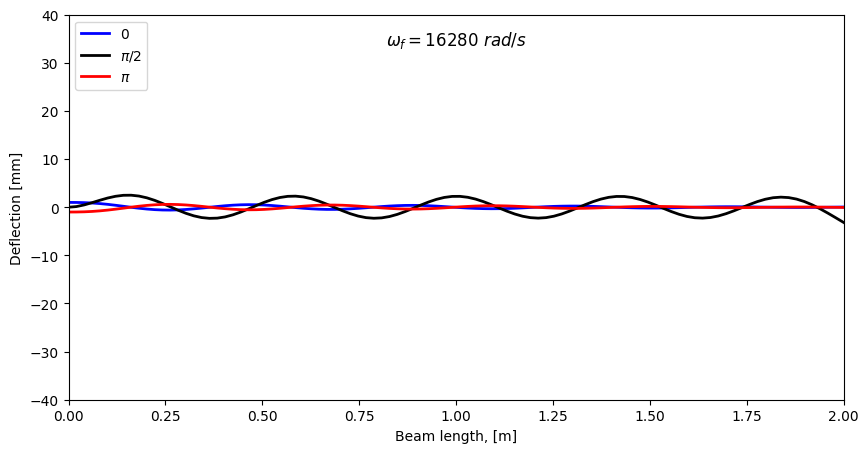

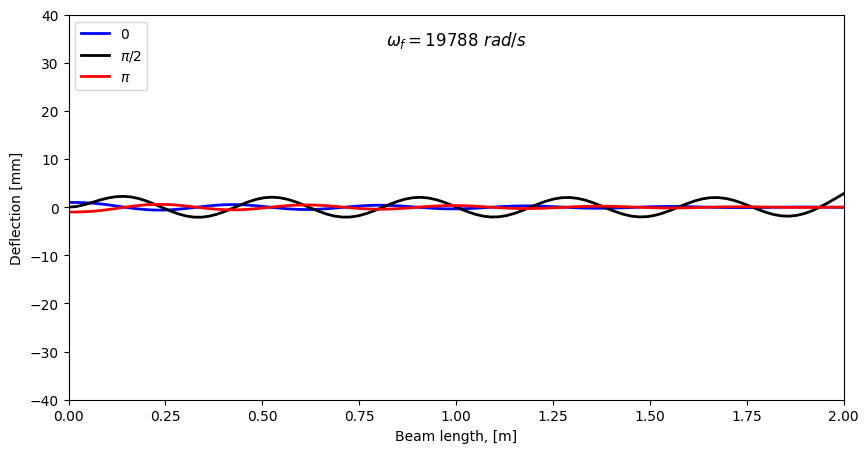

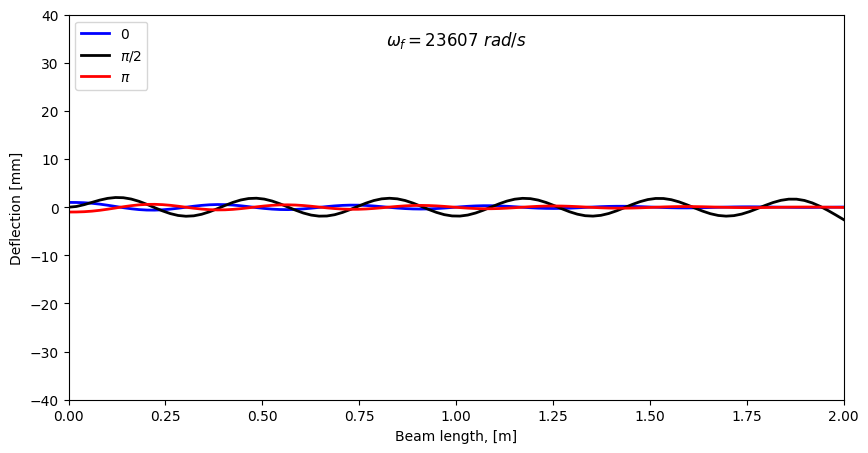

In [5]:
%matplotlib inline
displs = []
omegas = np.concatenate([[1, 100], omegan])
for omegaf in omegas:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk 
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    Uu = solve(Huu, Fk)
    
    U[bu] = Uu
    U[1] = amplitude
    displs.append(U[1::DOF].copy())
    
    plt.figure()
    ax = plt.gca()
    y = 1000*U[1::DOF]
    phase = np.arctan2(y.imag, y.real)
    plt.plot(xmesh, np.cos(phase)*np.abs(y), 'b-', label='0')
    tmp = np.cos(phase + pi/2)*np.abs(y)
    plt.plot(xmesh, tmp, 'k-', label='$\\pi/2$')
    plt.plot(xmesh, np.cos(phase + pi)*np.abs(y), 'r-', label='$\\pi$')
    plt.title('$\\omega_f=%1.0f\\ rad/s$' % omegaf, y=0.9)
    plt.legend(loc='upper left')
    plt.xlim(0, Lbeam)
    #plt.ylim(min(-0.5,tmp.min()*1.25), tmp.max()*1.25)
    plt.ylim(-40, 40)
    plt.xlabel('Beam length, [m]')
    plt.ylabel('Deflection [mm]')
    
displs = np.asarray(displs)
print(omegan[omegan < omegas.max()])
print('ready')

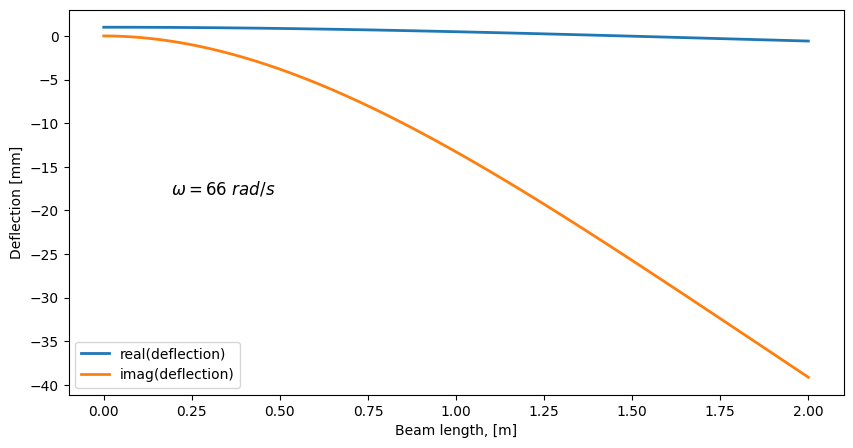

In [6]:
deflection = 1000*displs[2]
plt.xlabel('Beam length, [m]')
plt.ylabel('Deflection [mm]')
plt.title('$\\omega=%1.0f\\ rad/s$' % omegas[2], x=0.2, y=0.5)
line_real, = plt.plot(x, deflection.real, label='real(deflection)')
line_imag, = plt.plot(x, deflection.imag, label='imag(deflection)')
plt.legend()


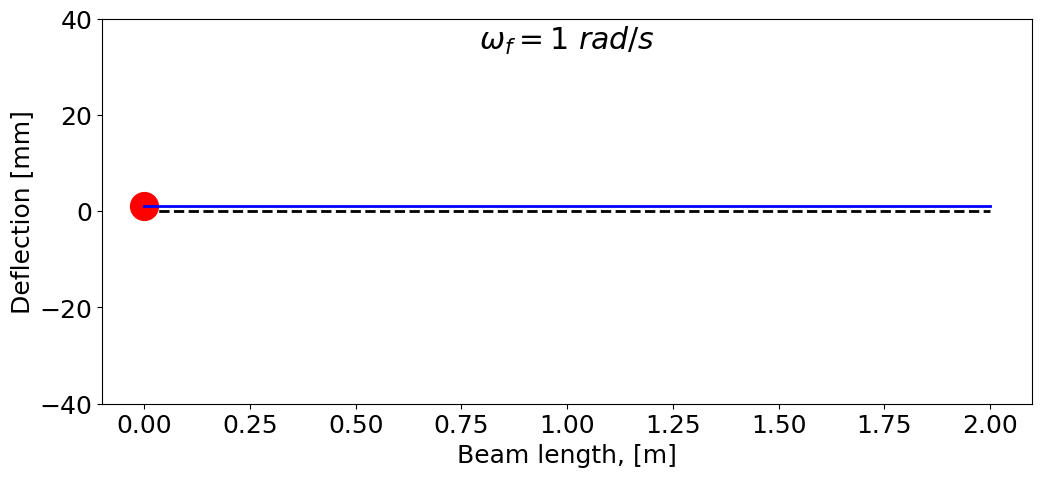

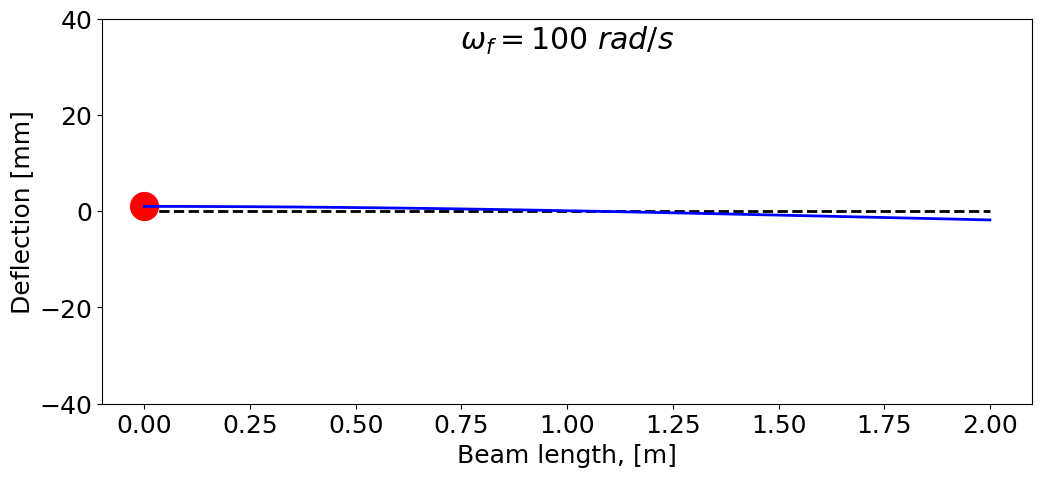

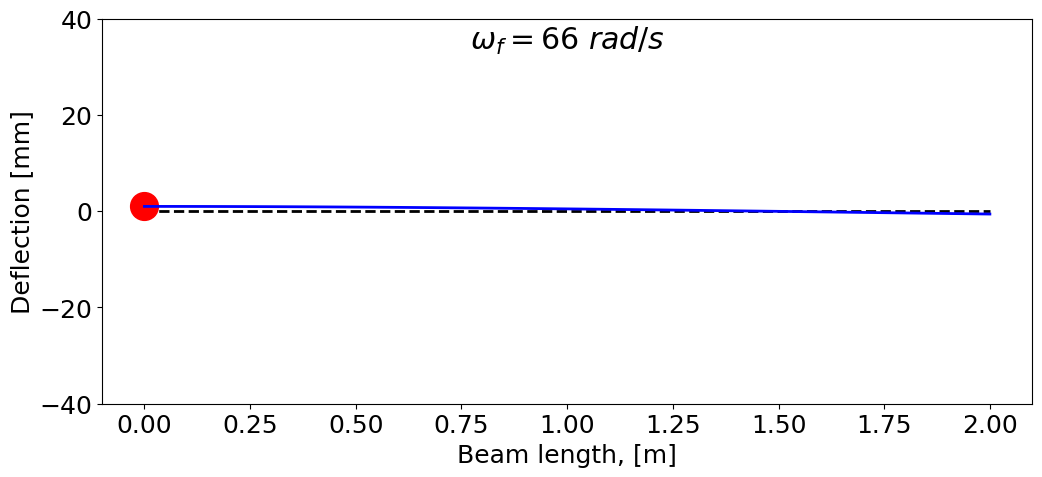

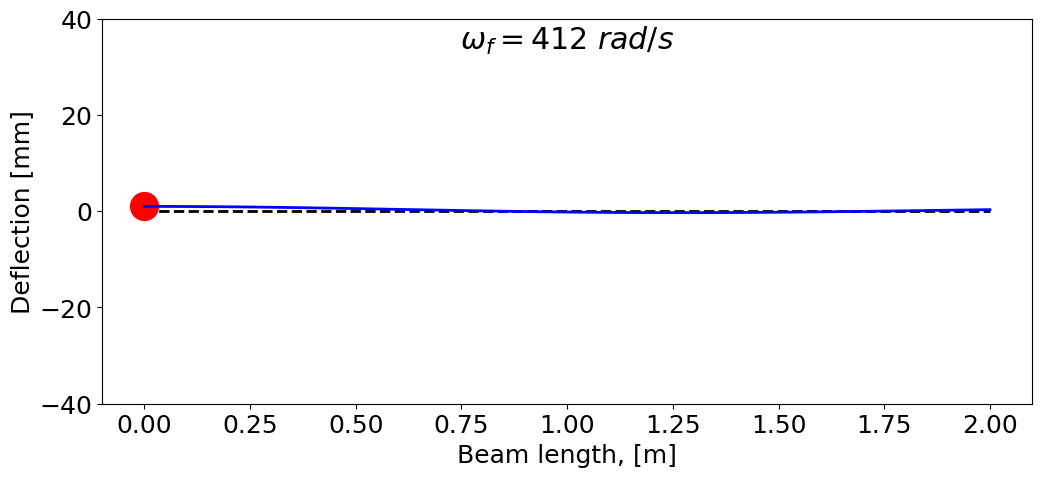

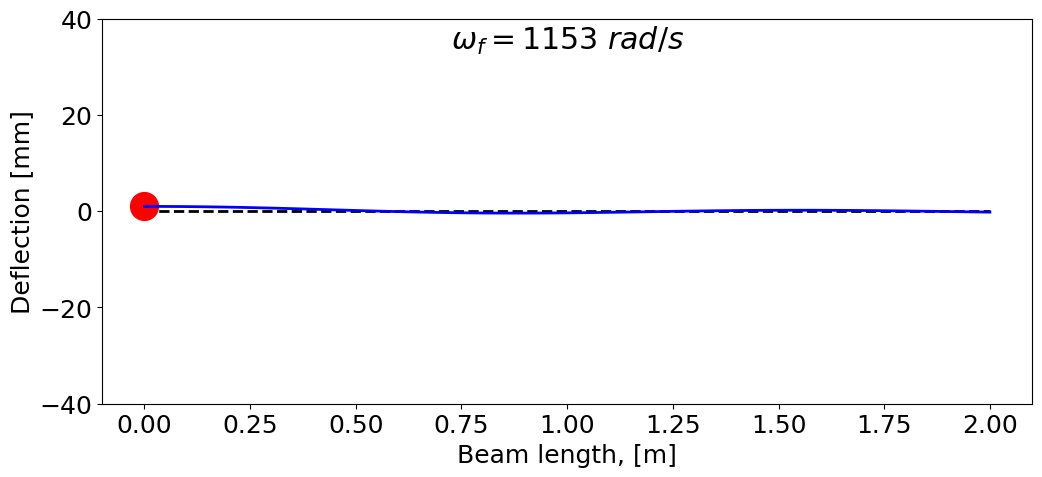

In [7]:
from matplotlib import animation

for ind in range(5):
    matplotlib.rcParams['font.size'] = 18
    deflection = 1000*displs[ind]
    fig = plt.figure(figsize=(12, 5))
    plt.xlabel('Beam length, [m]')
    plt.ylabel('Deflection [mm]')
    plt.title('$\\omega_f=%1.0f\\ rad/s$' % omegas[ind], y=0.9)
    excitation = np.ones_like(x)*amplitude
    plt.plot(x, np.zeros_like(x), 'k--')
    line_excitation, = plt.plot(x[:1], excitation[:1], 'ro', ms=20)
    line_deflection, = plt.plot(x, np.abs(deflection), 'b-')
    phase = np.arctan2(deflection.imag, deflection.real)
    plt.ylim(-40, 40)
    nframes = 240
    angles = np.linspace(0, 10*pi, nframes)

    def animate(i=0):
        line_excitation.set_ydata(1000*np.cos(angles[i])*excitation[:1])
        line_deflection.set_ydata(np.cos(angles[i] + phase)*np.abs(deflection))
        return line_excitation, line_deflection
    
    anim = animation.FuncAnimation(fig, animate, init_func=animate,
                               frames=nframes, interval=20, blit=True)
    # call function to save the animation
    anim.save('mdoffreq04_direct_FRA_omegaf_%03d.mp4' % int(omegas[ind]), fps=60)
